In [2]:
import json
import pdal

pipeline_dict = {
  "pipeline": [
    {
      "type": "readers.copc",
      "filename": "https://stac.uixai.org/data/kasugai-station.copc.laz",
      "bounds": "([12600, 12700], [-37450, -37315])"
    }
  ]
}

pipe = pdal.Pipeline(json.dumps(pipeline_dict))
count = pipe.execute()
count


184487

In [12]:
import numpy as np
import pandas as pd

arr = pipe.arrays[0]
df = pd.DataFrame({
    "X": arr["X"],
    "Y": arr["Y"],
    "Z": arr["Z"],
    **({"Intensity": arr["Intensity"]} if "Intensity" in arr.dtype.names else {}),
    **({"Classification": arr["Classification"]} if "Classification" in arr.dtype.names else {}),
})
df.head()


,X,Y,Z,Intensity,Classification
0,12650.00,-37412.84,274.15,0,1
1,12650.00,-37380.78,274.34,0,2
2,12650.01,-37444.79,273.87,0,1
3,12650.01,-37437.08,275.71,0,1
4,12650.01,-37432.96,274.07,0,1


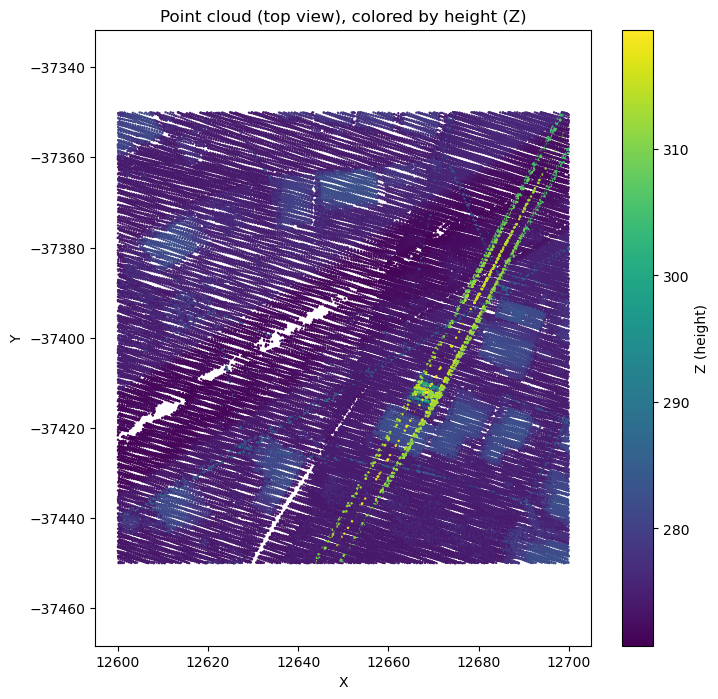

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(df["X"], df["Y"], s=0.5, c=df["Z"])  # s 是点大小；c 用 Z 上色
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Point cloud (top view), colored by height (Z)")
plt.axis("equal")   # 保证 X/Y 比例一致，不会被拉伸
plt.colorbar(label="Z (height)")
plt.show()


In [17]:
import numpy as np

res = 1.0  # 网格大小（米）

x = df["X"].to_numpy()
y = df["Y"].to_numpy()
z = df["Z"].to_numpy()

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

nx = int(np.ceil((xmax - xmin) / res))
ny = int(np.ceil((ymax - ymin) / res))

nx, ny


(100, 100)

In [18]:
ix = np.floor((x - xmin) / res).astype(int)
iy = np.floor((y - ymin) / res).astype(int)

ix = np.clip(ix, 0, nx - 1)
iy = np.clip(iy, 0, ny - 1)

grid = np.full((ny, nx), np.nan, dtype=np.float32)

for i in range(len(z)):
    yy, xx = iy[i], ix[i]
    val = z[i]
    if np.isnan(grid[yy, xx]) or val > grid[yy, xx]:
        grid[yy, xx] = val


In [19]:
grid.shape
np.nanmin(grid), np.nanmax(grid)


(np.float32(270.84), np.float32(319.43))

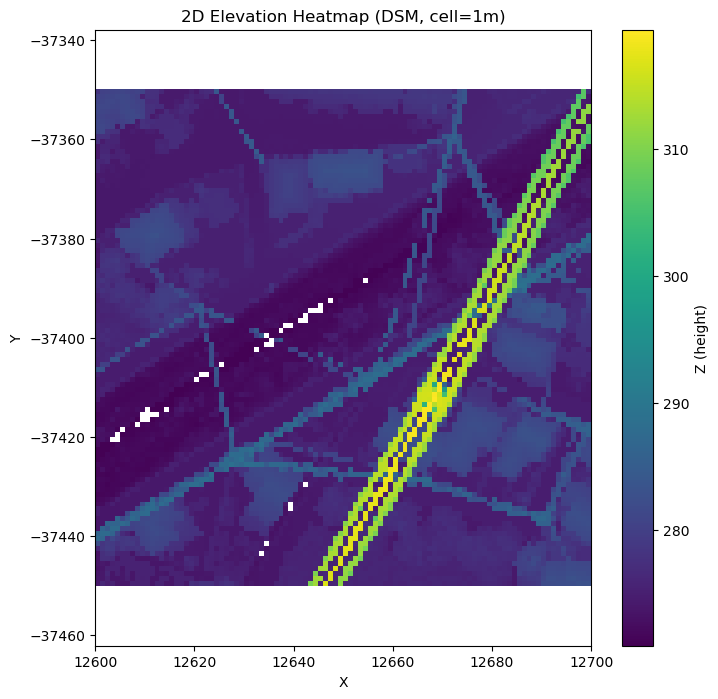

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(
    grid,
    origin="lower",
    extent=[xmin, xmax, ymin, ymax],
    interpolation="nearest"
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Elevation Heatmap (DSM, cell=1m)")
plt.colorbar(label="Z (height)")
plt.axis("equal")
plt.show()


In [21]:
if "Classification" in df.columns:
    print(df["Classification"].value_counts().head(10))
else:
    print("No Classification column")


Classification
1    87907
2    53909
9     6715
Name: count, dtype: int64


In [22]:
df_ground = df[df["Classification"] == 2].copy()
len(df_ground)


53909

In [23]:
xg = df_ground["X"].to_numpy()
yg = df_ground["Y"].to_numpy()
zg = df_ground["Z"].to_numpy()


In [24]:
ixg = np.floor((xg - xmin) / res).astype(int)
iyg = np.floor((yg - ymin) / res).astype(int)

ixg = np.clip(ixg, 0, nx - 1)
iyg = np.clip(iyg, 0, ny - 1)

dem = np.full((ny, nx), np.nan, dtype=np.float32)

for i in range(len(zg)):
    yy, xx = iyg[i], ixg[i]
    val = zg[i]
    if np.isnan(dem[yy, xx]) or val < dem[yy, xx]:
        dem[yy, xx] = val


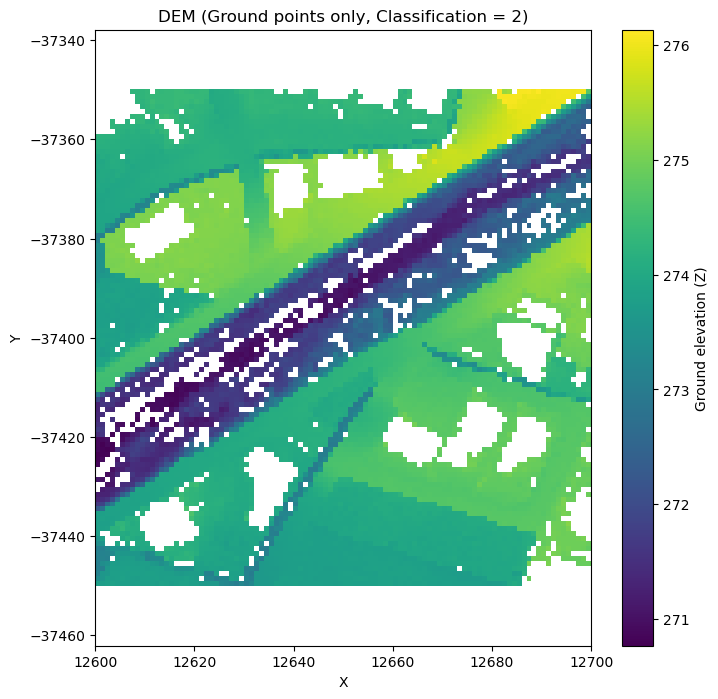

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(
    dem,
    origin="lower",
    extent=[xmin, xmax, ymin, ymax],
    interpolation="nearest"
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("DEM (Ground points only, Classification = 2)")
plt.colorbar(label="Ground elevation (Z)")
plt.axis("equal")
plt.show()
